In [27]:
import numpy as np
import matplotlib.pyplot as plt

In [28]:
def print_data(*data):
    for d in data:
        print(f'Min: {d.min()}, Max: {d.max()}, shape: {d.shape}, dtype: {d.dtype}')

In [29]:
embedding_dim = 50
vocab_size = 10
seq_length = 20

In [30]:

fixed_embedding = np.random.rand(embedding_dim)
embedding_data = np.tile(fixed_embedding, (seq_length, 1))

word_indices = np.random.randint(0, vocab_size, size=(seq_length,))
one_hot_output = np.eye(vocab_size)[word_indices] # one_hot

print("Embedding Data (first 2 rows):")
print(embedding_data[:2])
print("\nOne-hot Output (word indices):")
print(one_hot_output)

X = embedding_data
y = one_hot_output

Embedding Data (first 2 rows):
[[0.63920329 0.82636157 0.82516412 0.76925228 0.56918717 0.3655586
  0.60414297 0.34794491 0.82730789 0.16315537 0.72871497 0.9937678
  0.38754125 0.76802644 0.54053611 0.63493671 0.60915767 0.74554753
  0.53103355 0.12732589 0.49675479 0.11497618 0.76062938 0.41483401
  0.42439436 0.27275543 0.30144108 0.07585207 0.28080001 0.719119
  0.47403493 0.40320252 0.31933972 0.04335237 0.86075602 0.06877549
  0.11901661 0.35632504 0.87000961 0.15915874 0.33378226 0.5951469
  0.08983269 0.09493977 0.35862765 0.05176116 0.12883103 0.73881898
  0.05438639 0.27118216]
 [0.63920329 0.82636157 0.82516412 0.76925228 0.56918717 0.3655586
  0.60414297 0.34794491 0.82730789 0.16315537 0.72871497 0.9937678
  0.38754125 0.76802644 0.54053611 0.63493671 0.60915767 0.74554753
  0.53103355 0.12732589 0.49675479 0.11497618 0.76062938 0.41483401
  0.42439436 0.27275543 0.30144108 0.07585207 0.28080001 0.719119
  0.47403493 0.40320252 0.31933972 0.04335237 0.86075602 0.06877549
 

In [31]:
def tanh(x, derv=False):
    if derv: return 1 - np.tanh(x)**2
    return np.tanh(x)

In [32]:
def derv_tanh(x):
    return 1 - x**2

In [33]:
def sigmoid(x, derv=False):
    s = 1 / (1 + np.exp(-x))
    if derv: return s * (1 - s)
    return s

In [34]:
def derv_sigmoid(x):
    return x * (1 - x)

In [35]:
def softmax(x, derv=False):
    x_exp = np.exp(x - np.max(x, axis=1, keepdims=True))
    s = x_exp / np.sum(x_exp, axis=1, keepdims=True)
    if derv: return s * (1 - s)
    return s

In [36]:
def CCE(y, y_pred, derv=False):
    if derv: return y_pred-y # CCE + softmax
    return np.mean(-y*np.log(y_pred+1e-8))

In [37]:
INPUT_SIZE = embedding_dim
HIDDEN_SIZE = 50
OUTPUT_SIZE = vocab_size

In [38]:
def init_weights():
    U = np.random.randn(INPUT_SIZE, HIDDEN_SIZE) * np.sqrt(2/(INPUT_SIZE+HIDDEN_SIZE))
    W = np.random.randn(HIDDEN_SIZE, HIDDEN_SIZE) * np.sqrt(1/HIDDEN_SIZE)
    b = np.zeros((1, HIDDEN_SIZE))
    return U, W, b

In [39]:
Uf, Wf, bf = init_weights()
Ui, Wi, bi = init_weights()
Uo, Wo, bo = init_weights()
Ug, Wg, bg = init_weights()

DenseW = np.random.randn(HIDDEN_SIZE, OUTPUT_SIZE)
Denseb = np.zeros((1, OUTPUT_SIZE))

params = [Uf, Wf, bf, Ui, Wi, bi, Uo, Wo, bo, Ug, Wg, bg, DenseW, Denseb]
len_params = len(params)

In [40]:
# Adam settings
lr = 0.001
current_lr = lr
decay = 0
t = 1
m = [0] * len_params
v = [0] * len_params
beta_1 = 0.9
beta_2 = 0.999
epsilon_adam = 1e-8

In [41]:
def optimizer_adam(grads, i):
    m[i] = beta_1 * m[i] + (1 - beta_1) * grads
    v[i] = beta_2 * v[i] + (1 - beta_2) * grads**2
    m_h = m[i] / (1 - beta_1**t)
    v_h = v[i] / (1 - beta_2**t)
    return m_h / (np.sqrt(v_h) + epsilon_adam)

In [42]:
def prev_update():
    global current_lr
    if decay:
        current_lr = lr * (1 / (1 + decay * t))

In [43]:
def step():
    global t
    t += 1

In [44]:
def update_params(grads):
    prev_update()
    for i in range(len_params):
        params[i] -= current_lr * optimizer_adam(grads[i], i)
    step()

In [45]:
def forward_cell(xt, h_prev, c_prev):
    ft = sigmoid(xt @ Uf + h_prev @ Wf + bf)
    it = sigmoid(xt @ Ui + h_prev @ Wi + bi)
    ot = sigmoid(xt @ Uo + h_prev @ Wo + bo)
    candt = tanh(xt @ Ug + h_prev @ Wg + bg)

    ct = ft * c_prev + it * candt
    ht = tanh(ct) * ot
    return ht, ct, candt, ot, it, ft

In [46]:
def forward(x):
    T = x.shape[0]

    H = np.zeros((T+1, 1, HIDDEN_SIZE))
    C = np.zeros((T+1, 1, HIDDEN_SIZE))


    Y = np.zeros((T, OUTPUT_SIZE))
    O = np.zeros((T, 1, HIDDEN_SIZE))
    I = np.zeros((T, 1, HIDDEN_SIZE))
    F = np.zeros((T, 1, HIDDEN_SIZE))
    Cand = np.zeros((T, 1, HIDDEN_SIZE))

    for t in range(T):
        H[t+1], C[t+1], candt, ot, it, ft = forward_cell(x[t], H[t], C[t])
        Y[t] = softmax(H[t+1] @ DenseW + Denseb)
        Cand[t] = candt
        O[t] = ot
        I[t] = it
        F[t] = ft
        
    return Y, H, C, O, I, F, Cand

In [47]:
def backward_cell(xt, h_prev, c_prev, c_current, candt, ot, it_gate, ft_gate, dh, dc_next):
    d_ot = dh * tanh(c_current)
    d_tanh_c = dh * ot
    d_c_from_h = d_tanh_c * tanh(c_current, derv=True)

    dct = d_c_from_h + dc_next
    
    d_ft = dct * c_prev
    d_it = dct * candt
    d_candt = dct * it_gate

    d_ft_pre = d_ft * derv_sigmoid(ft_gate)
    d_it_pre = d_it * derv_sigmoid(it_gate)
    d_ot_pre = d_ot * derv_sigmoid(ot)
    d_candt_pre = d_candt * derv_tanh(candt)

    dUft = xt.T @ d_ft_pre
    dWft = h_prev.T @ d_ft_pre
    dbft = np.sum(d_ft_pre, axis=0, keepdims=True)

    dUit = xt.T @ d_it_pre
    dWit = h_prev.T @ d_it_pre
    dbit = np.sum(d_it_pre, axis=0, keepdims=True)

    dUot = xt.T @ d_ot_pre
    dWot = h_prev.T @ d_ot_pre
    dbot = np.sum(d_ot_pre, axis=0, keepdims=True)

    dUgt = xt.T @ d_candt_pre
    dWgt = h_prev.T @ d_candt_pre
    dbgt = np.sum(d_candt_pre, axis=0, keepdims=True)

    dx_t = (d_ft_pre @ Uf.T +
                d_it_pre @ Ui.T +
                d_ot_pre @ Uo.T +
                d_candt_pre @ Ug.T)

    dh_prev = (d_ft_pre @ Wf.T +
                   d_it_pre @ Wi.T +
                   d_ot_pre @ Wo.T +
                   d_candt_pre @ Wg.T)
    
    dc_prev = dct * ft_gate

    return (dUft, dWft, dbft,
            dUit, dWit, dbit,
            dUot, dWot, dbot,
            dUgt, dWgt, dbgt,
            dh_prev, dc_prev, dx_t)

In [48]:
def init_grads(U, W, b):
    return np.zeros_like(U), np.zeros_like(W), np.zeros_like(b)

In [ ]:
def backward(x, y_true, y_pred, H, C, O, I, F, Cand, learn=True):
    T = x.shape[0]

    dUf, dWf, dbf = init_grads(Uf, Wf, bf)
    dUi, dWi, dbi = init_grads(Ui, Wi, bi)
    dUo, dWo, dbo = init_grads(Uo, Wo, bo)
    dUg, dWg, dbg = init_grads(Ug, Wg, bg)
    dDenseW = np.zeros_like(DenseW)
    dDenseb = np.zeros_like(Denseb)

    dh_next = np.zeros((1, HIDDEN_SIZE))
    dc_next = np.zeros((1, HIDDEN_SIZE))
    dx = np.zeros_like(x)

    for t in reversed(range(T)):
        xt = x[t:t+1]
        yt = y_true[t:t+1]
        outp = y_pred[t:t+1]
        h_prev = H[t]
        h_t = H[t+1]
        c_prev = C[t]
        c_t = C[t+1]
        candt = Cand[t]
        ot = O[t]
        it_gate= I[t]
        ft_gate= F[t]

        dEdy = CCE(yt, outp, derv=True)

        dDenseW += h_t.T @ dEdy
        dDenseb += np.sum(dEdy, axis=0, keepdims=True)
        
        dh = dEdy @ DenseW.T + dh_next

        (dUf_t, dWf_t, dbf_t,
         dUi_t, dWi_t, dbi_t,
         dUo_t, dWo_t, dbo_t,
         dUg_t, dWg_t, dbg_t,
         dh_next, dc_next, dx[t]) = backward_cell(xt, h_prev, c_prev, c_t, candt, ot, it_gate, ft_gate, dh, dc_next)

        dUf += dUf_t; dWf += dWf_t; dbf += dbf_t
        dUi += dUi_t; dWi += dWi_t; dbi += dbi_t
        dUo += dUo_t; dWo += dWo_t; dbo += dbo_t
        dUg += dUg_t; dWg += dWg_t; dbg += dbg_t

    dUf /= T; dWf /= T; dbf /= T
    dUi /= T; dWi /= T; dbi /= T
    dUo /= T; dWo /= T; dbo /= T
    dUg /= T; dWg /= T; dbg /= T
    dDenseW /= T; dDenseb /= T

    grads = dUf, dWf, dbf, dUi, dWi, dbi, dUo, dWo, dbo, dUg, dWg, dbg, dDenseW, dDenseb
    
    if learn:
        update_params(grads)

    return dx, grads

In [50]:
def train(x, y, epochs=100, batch_size=8, print_every=0.1):
    losses = []
    for epoch in range(1, epochs+1):
        for batch in range(0, x.shape[0], batch_size):
            x_batch = x[batch:batch+batch_size]
            y_batch = y[batch:batch+batch_size]
            y_pred, H, C, O, I, F, Cand = forward(x_batch)

            backward(x_batch, y_batch, y_pred, H, C, O, I, F, Cand, learn=True)

        loss = CCE(y, forward(x)[0])
        losses.append(loss)
        if epoch % max(1, int(epochs*print_every)) == 0:
            print(f'Epoch: [{epoch}/{epochs}]> Loss: {loss}')
            
    return losses

In [51]:
history_loss = train(x=X, y=y, epochs=100, batch_size=32, print_every=0.1)

Epoch: [10/100]> Loss: 0.19943274374723066
Epoch: [20/100]> Loss: 0.18654605191419946
Epoch: [30/100]> Loss: 0.17909503906902743
Epoch: [40/100]> Loss: 0.1716180650650128
Epoch: [50/100]> Loss: 0.1582982362381383
Epoch: [60/100]> Loss: 0.14129029337211102
Epoch: [70/100]> Loss: 0.12643219242139075
Epoch: [80/100]> Loss: 0.10924327933696552
Epoch: [90/100]> Loss: 0.09193413956733364
Epoch: [100/100]> Loss: 0.07298482550853334


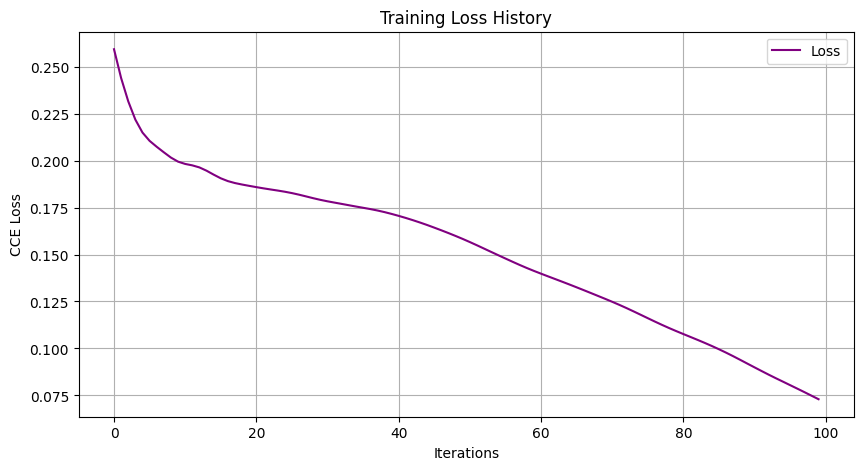

In [52]:
plt.figure(figsize=(10, 5))
plt.plot(np.array(history_loss), label='Loss', color='purple')
plt.title('Training Loss History')
plt.xlabel('Iterations')
plt.ylabel('CCE Loss')
plt.legend()
plt.grid(True)
plt.show()